In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 

import sys
sys.path.append(f'/home/beans/bespoke')
from constants import *

import matplotlib.pyplot as plt
from viz_utils import draw_wps
from blender_dataloader import *
from constants import *
from imports import *
from train_utils import get_torque
from models import EffNet
from input_prep import *

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


In [2]:
m = EffNet(model_arch="efficientnet_b3").to(device) 

In [3]:
model_stem = "9.24_avg"
m.load_state_dict(torch.load(f"{BESPOKE_ROOT}/models/m_{model_stem}.torch"), strict=False)
sum([torch.numel(p) for p in m.parameters()]) / 1000

14029.957

In [4]:
m.hidden_init

Parameter containing:
tensor([[[ 9.6659e-03,  9.6321e-03,  4.0258e-03, -5.2424e-02,  2.3730e-03,
           6.4334e-03,  3.4905e-02, -3.8278e-03, -1.1348e-02, -9.0643e-02,
           1.3553e-01, -8.3839e-03, -7.6965e-03, -5.5418e-02, -2.7337e-02,
          -3.5724e-03, -1.2482e-02, -2.2409e-03, -6.1865e-03,  4.8785e-02,
           2.2175e-02,  9.0272e-02, -7.6350e-02,  1.4671e-01,  2.9994e-02,
           6.1666e-02,  3.1115e-02, -3.6699e-02,  3.3307e-02, -4.3357e-02,
          -7.3239e-02, -3.4101e-02, -7.6386e-02, -1.5469e-02, -5.0097e-02,
           6.6435e-03, -1.8902e-03, -1.4427e-03, -2.1088e-02, -9.9983e-03,
           8.8366e-02,  4.8942e-03,  2.8844e-02, -4.8202e-02,  4.8967e-03,
          -1.4501e-02,  1.2024e-02,  7.6186e-03, -1.2424e-01,  1.5267e-03,
          -2.2117e-02,  1.1172e-03,  2.6725e-02,  2.6995e-02,  1.2359e-01,
           4.0177e-02, -3.3801e-03, -4.3741e-02, -1.1496e-01, -4.5135e-03,
           6.8559e-02, -2.0977e-02, -1.9702e-02, -2.7213e-02, -1.6996e-02,
   

In [5]:
dataloader = BlenderDataloader("trn", 8)

In [6]:
imgs_all, wp_angles_all, auxs_all, angle_preds_all = [], [], [], []

with torch.no_grad():
    for i in range(20):
        batch, is_first_in_seq = dataloader.get_batch()

        (img, 
            aux, 
            wp_angles,
             wp_headings,
             wp_curvatures,
             to_pred_mask,
            current_tire_angles_rad, # Extras
            current_speeds_mps, 
            pitch, 
            yaw) = batch


        if is_first_in_seq: 
            print("first in seq")
            m.reset_hidden(dataloader.bs) # reset hiddens to zeros

        with torch.cuda.amp.autocast(): 
            pred, obs_net_out = m(img, aux)
            wp_angles_pred, wp_headings_pred, wp_curvatures_pred = torch.chunk(pred, 3, -1)
            
        img = (denorm_img(img) * 255).permute(0,1,3,4,2).cpu().numpy().astype('uint8')  
        wp_angles = (wp_angles.cpu() * TARGET_NORM).numpy()
        wp_angles_pred = (wp_angles_pred.cpu() * TARGET_NORM).numpy()        
        
        imgs_all.append(img)
        wp_angles_all.append(wp_angles)
        angle_preds_all.append(wp_angles_pred)
        
        aux = (aux.cpu()*aux_norm_constants).cpu().numpy()
        auxs_all.append(aux)
        
imgs_all = np.concatenate(imgs_all, axis=1)
wp_angles_all = np.concatenate(wp_angles_all, axis=1)
angle_preds_all = np.concatenate(angle_preds_all, axis=1)
auxs_all = np.concatenate(auxs_all, axis=1)

imgs_all.shape, wp_angles_all.shape, angle_preds_all.shape, auxs_all.shape

first in seq


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


((8, 180, 120, 640, 3), (8, 180, 30), (8, 180, 30), (8, 180, 5))

In [7]:
bs, cat_seq_len, height, width, channels = imgs_all.shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/dataloader_{model_stem}.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for b in range(bs):
    for s in range(cat_seq_len):

        img = imgs_all[b,s,:,:,:]
        targets = wp_angles_all[b,s,:]
        preds = angle_preds_all[b,s,:]
        speed_mps = kph_to_mps(auxs_all[b,s,2])
        
        # wps
        img = draw_wps(img, targets, color=(100, 200, 200), thickness=-1, speed_mps=speed_mps)
        img = draw_wps(img, preds, speed_mps=speed_mps)

        # Guidelines
        img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
        img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center

        video.write(img)
    
video.release()
print("done")

done


In [32]:
np.concatenate(imgs_all, axis=1).shape

(4, 180, 100, 640, 3)

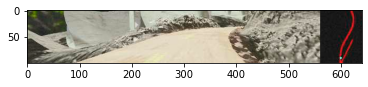

In [29]:
plt.imshow(img[0][0])

In [10]:
wp_angles.shape, wp_headings.shape, wp_curvatures.shape

(torch.Size([32, 9, 30]), torch.Size([32, 9, 30]), torch.Size([32, 9, 30]))

(array([ 113.,  456., 2223., 9196., 2566., 1304.,  827.,  425.,  119.,
          51.]),
 array([-2.883 , -2.066 , -1.251 , -0.4348,  0.3813,  1.197 ,  2.014 ,
         2.83  ,  3.645 ,  4.46  ,  5.277 ], dtype=float16),
 <BarContainer object of 10 artists>)

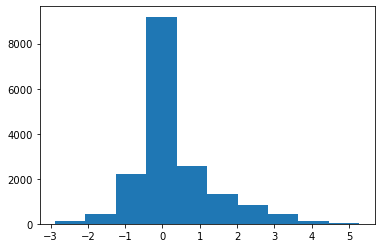

In [46]:
plt.hist((wp_angles*to_pred_mask).flatten().detach().cpu().numpy())

In [54]:
3.3*.54

1.782

(array([  16.,   90.,  505., 3027., 9853., 1779., 1425.,  435.,   85.,
          65.]),
 array([-5.066 , -3.883 , -2.697 , -1.514 , -0.3289,  0.8555,  2.04  ,
         3.225 ,  4.41  ,  5.594 ,  6.777 ], dtype=float16),
 <BarContainer object of 10 artists>)

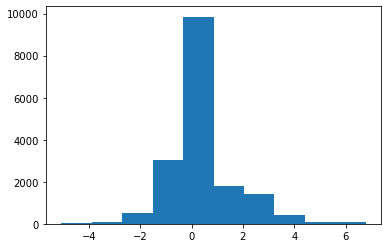

In [47]:
plt.hist((wp_headings*to_pred_mask).flatten().detach().cpu().numpy())

(array([  149.,   688.,  2620., 10216.,  1754.,  1274.,   414.,    76.,
           20.,    69.]),
 array([-0.991 , -0.687 , -0.3823, -0.078 ,  0.2263,  0.531 ,  0.835 ,
         1.14  ,  1.444 ,  1.748 ,  2.053 ], dtype=float16),
 <BarContainer object of 10 artists>)

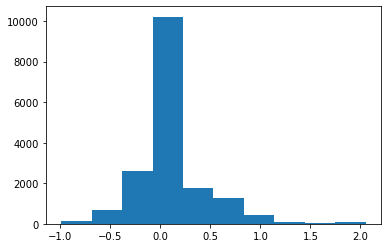

In [48]:
plt.hist((wp_curvatures*to_pred_mask).flatten().detach().cpu().numpy())

In [35]:
to_pred_mask.sum() / to_pred_mask.numel()

tensor(0.8145, device='cuda:0', dtype=torch.float16)

In [36]:
t = get_torque(wp_angles, aux)
plt.hist(t.cpu().numpy().flatten())

IndexError: index 9 is out of bounds for axis 1 with size 9

In [49]:
abs(t).max()

tensor(3904., device='cuda:0', dtype=torch.float16)

(array([161.,  60.,  19.,   8.,   4.,   2.,   1.,   0.,   0.,   1.]),
 array([  0. ,  62.6, 125.2, 187.8, 250.4, 313. , 375.5, 438.2, 500.8,
        563.5, 626. ], dtype=float16),
 <BarContainer object of 10 artists>)

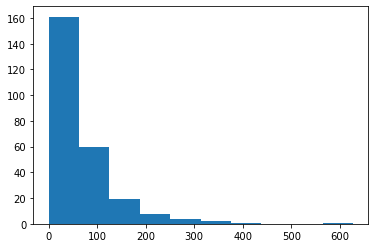

In [50]:
td = abs(t[:,1:,:] - t[:,:-1,:])
plt.hist(td.cpu().numpy().flatten())

In [51]:
abs(td).max()

tensor(626., device='cuda:0', dtype=torch.float16)

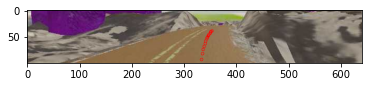

In [67]:

traj = dataloader.targets_chunk[ix][0]
img = dataloader.img_chunk[ix][0]

plt.imshow(draw_wps(img, traj))

In [8]:
import subprocess

In [9]:
# Load up membank from ssd to shm
subprocess.run("cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank", shell=True)

CompletedProcess(args='cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank', returncode=0)

In [ ]:
# save membank to ssd
subprocess.run("cp -R /dev/shm/blender_membank /media/beans/beans_data/blender_membank", shell=True)